CONTEXT:

Given the launch of our food truck line, FoodX, we will be running an exciting and interactive promotion on college campuses to attract a massive initial student following.  When placing their order on our fancy new FoodX app they input basic information about their college experience and we predict what they are going to order.  If we don’t get it right they get a 10% discount.

While the promotion has done a great job of bringing in business our staff has not been great at guessing orders and are not happy with the combined workload of guessing and cooking.

Because of this you have been asked to consider implications, solutions and deployment of a mechanism to automatically guess orders, sounds like the perfect job for AI!

TASK:

1) Exploratory data analysis to get a feel for the distributions and biases of the data.  Report any visualizations and findings used and suggest any other impactful business use cases for that data.

2) Consider implications of data collection, storage, and data biases you would consider relevant here considering Data Ethics, Business Outcomes, and Technical Implications

3) Build a model to predict a customers order from their available information.

4) Given the work required to bring a solution like this to maturity and its performance, what considerations would you make to determine if this is a suitable course of action?


In [2]:
print("*"*100)

****************************************************************************************************


LIBRARIES

In [3]:
#For numeric and dataframe operations.
import numpy as np
import pandas as pd

#For visualization.
import matplotlib.pyplot as plt
import seaborn as sns

#For data pipeline creation.
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

#For data preprocessing.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#For Model selection.
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#For model testing.
from sklearn.metrics import (recall_score, precision_score, f1_score,
                             confusion_matrix, classification_report)

#For model exporting and importing.
import pickle

In [4]:
print("*"*100)

****************************************************************************************************


DATA LOADING

In [5]:
#I have stored the data in the google drive cloud.
#Connecting this notebook to google drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
#Loading the data into colab from google drive.
df_original = pd.read_csv("/content/drive/MyDrive/Datasets/Xtern FoodX college food truck data.csv")

#Creating a copy to work on.
df = df_original.copy()

In [7]:
print("*"*100)

****************************************************************************************************


DATA OVERVIEW

In [8]:
#Checking the shape of the dataframe.
df.shape

(5000, 5)

In [9]:
#Checking feature data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        5000 non-null   object
 1   Major       5000 non-null   object
 2   University  5000 non-null   object
 3   Time        5000 non-null   int64 
 4   Order       5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


In [10]:
#Checking inital view of numeric features.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,5000.0,12.5282,1.357193,8.0,12.0,13.0,13.0,17.0


In [11]:
#Checking for missing values.
df.isna().sum()

Year          0
Major         0
University    0
Time          0
Order         0
dtype: int64

In [12]:
#Checking for duplicated values.
df.duplicated().sum()

3604

In [13]:
#Looking at duplicated entries.
df.iloc[4995:4999]

,Year,Major,University,Time,Order
4995,Year 2,Mathematics,Ball State University,11,Breaded Pork Tenderloin Sandwich
4996,Year 3,Astronomy,Indiana State University,12,Ultimate Grilled Cheese Sandwich (with bacon a...
4997,Year 3,Chemistry,Butler University,13,Sugar Cream Pie
4998,Year 3,Astronomy,Butler University,15,Sugar Cream Pie


These are clearly not duplicates. This will be ignored.

In [14]:
#Initial look at the dataframe.
df.sample(n=5)

,Year,Major,University,Time,Order
4413,Year 3,Physics,Ball State University,12,Indiana Corn on the Cob (brushed with garlic b...
1352,Year 2,Physics,Indiana State University,13,Ultimate Grilled Cheese Sandwich (with bacon a...
1141,Year 3,Accounting,Butler University,10,Indiana Corn on the Cob (brushed with garlic b...
3466,Year 2,Economics,Butler University,11,Indiana Pork Chili
4159,Year 3,Economics,Indiana State University,13,Hoosier BBQ Pulled Pork Sandwich


In [15]:
#Looking at the possible values in the object dtype columns.
for feature in df.select_dtypes(include="object").columns:
  print(feature.upper())
  print(df[feature].value_counts(normalize=True))
  print("-"*50)

YEAR
Year 3    0.5438
Year 2    0.4546
Year 1    0.0010
Year 4    0.0006
Name: Year, dtype: float64
--------------------------------------------------
MAJOR
Chemistry                  0.1280
Biology                    0.1270
Astronomy                  0.1238
Physics                    0.1220
Mathematics                0.1164
Economics                  0.1022
Business Administration    0.0668
Political Science          0.0618
Marketing                  0.0478
Anthropology               0.0292
Finance                    0.0270
Psychology                 0.0152
Accounting                 0.0124
Sociology                  0.0062
International Business     0.0058
Music                      0.0042
Mechanical Engineering     0.0022
Philosophy                 0.0008
Fine Arts                  0.0006
Civil Engineering          0.0006
Name: Major, dtype: float64
--------------------------------------------------
UNIVERSITY
Butler University                                            0.3228
India

TAKE-AWAYS:

1)Since there are only 5,000 entries in the data, there may not be enough information to fit a neural network.

2)Depending on the amount of independent variables we are left with after OneHotEncoding the categorical variables, we could start to run into curse of dimensionality issues having only 5,000 data entries.

3)There are hardly any Year 1 and Year 4 students.

4)There are many majors with less than 5% representation.

5)There are many universities with less than 5% representation.

6)The order class is very balanced so no over/undersampling will need to be done.

In [16]:
print("*"*100)

****************************************************************************************************


EDA ANALYSIS

In [17]:
#Function that combines histogram and box plot.

def histo_box(data,feature,figsize=(12,10), binwidth=None):
  #Easy variable.
  data1 = data[feature]

  #Create subplot
  fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=figsize)

  #histogram
  sns.histplot(data=data, x=feature, binwidth=binwidth, alpha=0.9, color="b", ax=ax1)
  ax1.set_ylabel("Frequency")

  #box plot
  sns.boxplot(data=data, x=feature, orient="h", ax=ax2)
  ax2.set_ylabel("Box plot")
  ax2.set_xlabel("Working hours per week")

  #Adding quartiles.
  median = np.median(data1)
  quartile = np.percentile(data1, [25,75])

  ax1.axvline(x=median, color="r", linestyle="-", linewidth=3)
  ax1.axvline(x=quartile[0], color="y", linestyle="--", linewidth=3)
  ax1.axvline(x=quartile[1], color="y", linestyle="--", linewidth=3)

  ax2.axvline(x=median, color="r", linestyle="-", linewidth=3, label="Median")
  ax2.axvline(x=quartile[0], color="y", linestyle="--", linewidth=3, label="25th %")
  ax2.axvline(x=quartile[1], color="y", linestyle="--", linewidth=3, label="75th %")

  #Adding quartile values to graph
  for value, label in zip([quartile[0], median, quartile[1]], ["25th %", "Median", "75th %"]):
    ax2.text(value, 1.05, f"{label}:\n{value:.2f}", transform=ax2.get_xaxis_transform(), color="black")

  ax2.legend() #Showing legend on chart

  #No extra spacing
  plt.tight_layout()

  #show plot
  plt.show()

In [18]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    sorted_order = data[feature].value_counts().index[:n].sort_values()
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=sorted_order)

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

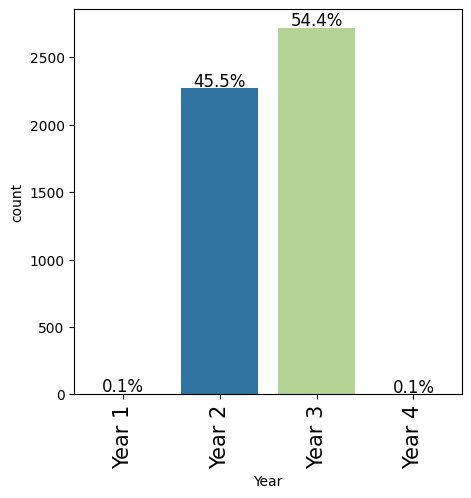

**************************************************


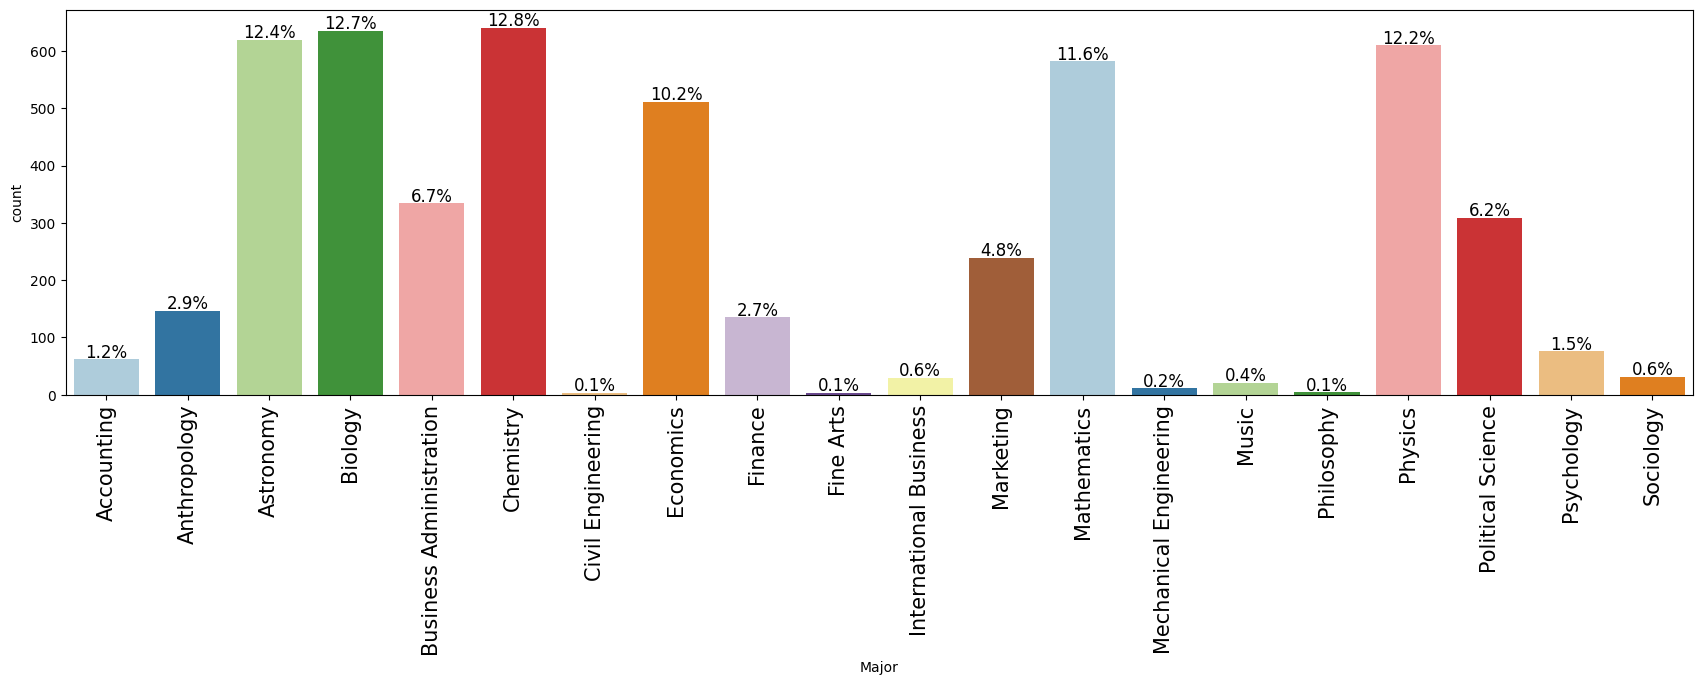

**************************************************


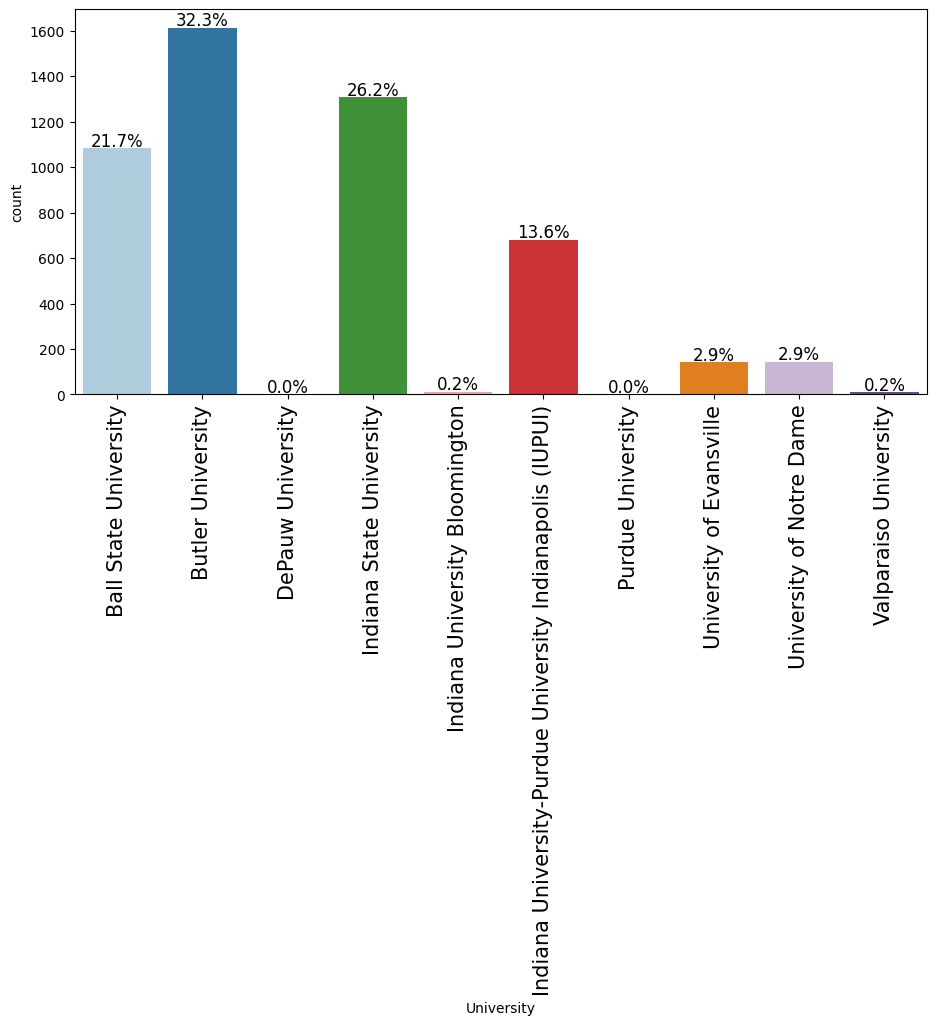

**************************************************


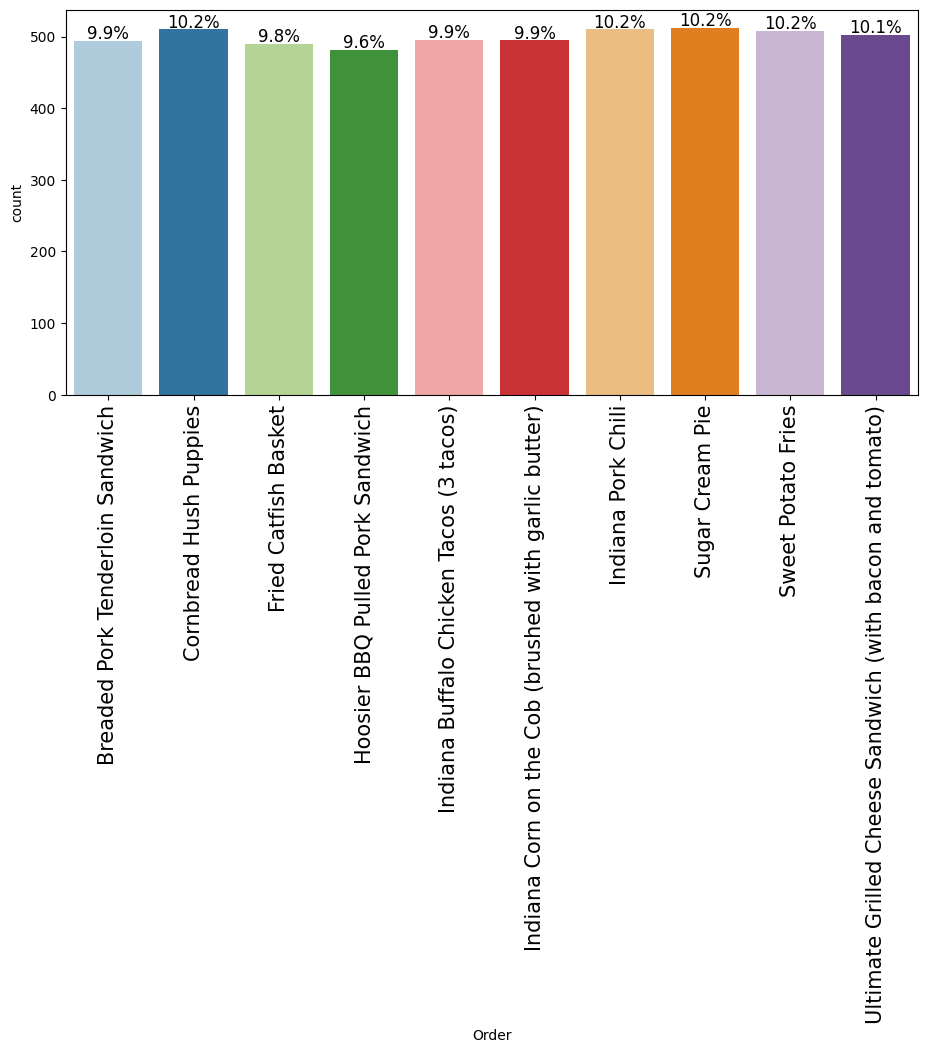

**************************************************


In [19]:
#Visualizing the categorical varaibles.
for feature in df.select_dtypes(include="object").columns:
  labeled_barplot(df,feature, perc=True)
  print("*"*50)

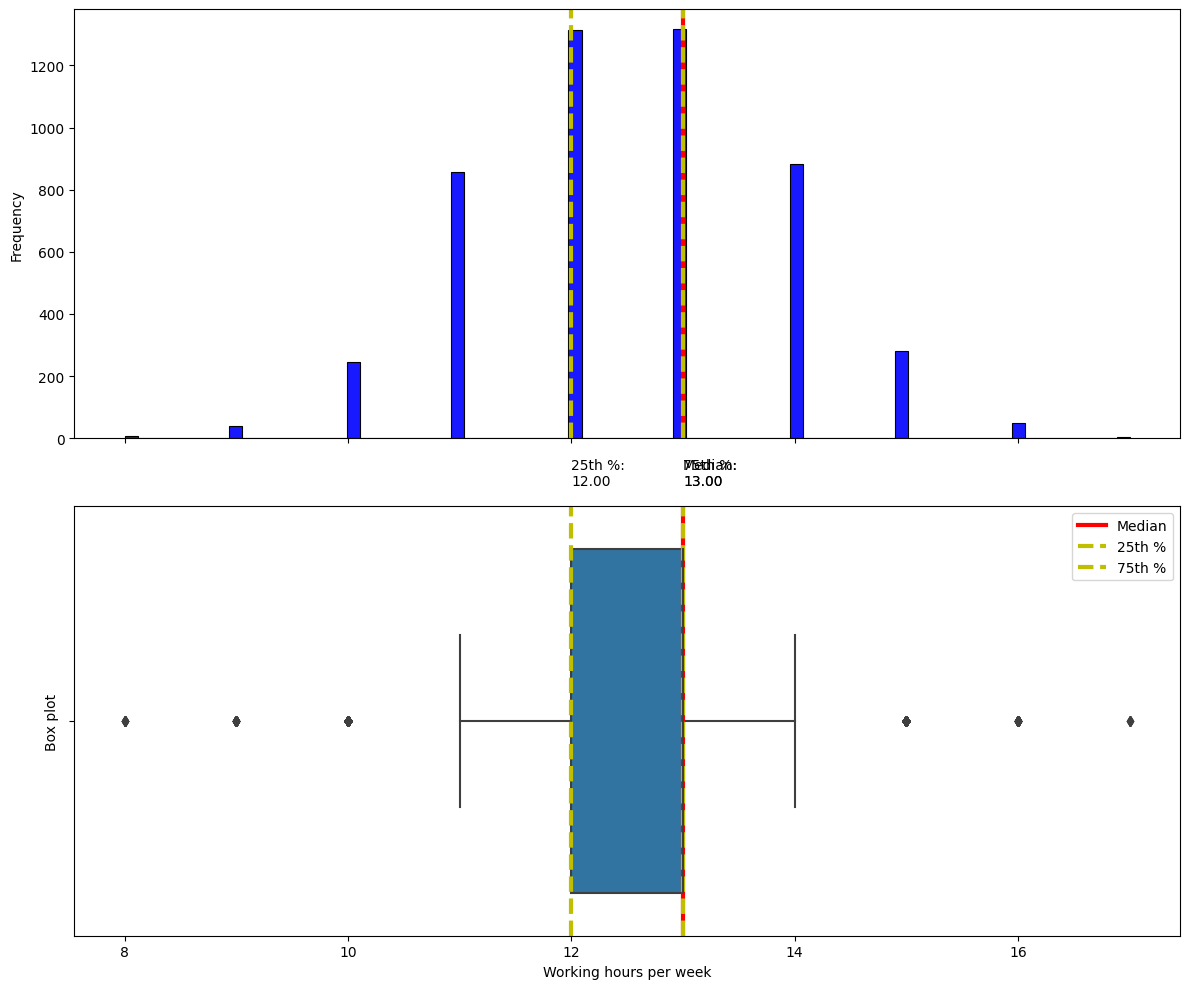

In [20]:
#Visualizing the numeric variable.
histo_box(df,"Time")

In [21]:
#Getting relevant quantiles for the box plot above.
quant_95 = df["Time"].quantile(0.975)
quant_05  =df["Time"].quantile(0.025)
print(f"Almost all work between {quant_05} and {quant_95} hours a week.")

Almost all work between 10.0 and 15.0 hours a week.


In [22]:
print("*"*100)

****************************************************************************************************


25%

FINDINGS:

1)95% of students work between 10 and 15 hours a week and half of all the students work 12 to 13 hours a week.

2)Most of the students are at Butler University, Indiana State, Ball state, or Purdue.

3)Some majors are a lot more popular than others.

4)Most of the students are either year 2 or year 3.

OTHER BUSINESS USE FOR THE DATA:

1)Given the distribution of students among universities, this data can be used to explore the difference in college application/admission among the colleges listed.

2)Given the distribution of majors among the students, this data can be used to explore the difference in major preferences.

3)Given the distribution of years among the students, this data can be used to dive deeper into why prodominantly second year and third year students placed orders through the app.

30%

ETHICAL IMPLICATIONS:

There is no information collected in this dataset that contains sensitive details and that could cause any damange to the person it was collected from. Storing this data, if it is stored, shouldn't be a problem and there are no data biases involved in this case.

BUSINESS IMPLICATIONS:

Since so little data was gathered and stored from some universities and some majors, there will likely be low accuracy when trying to predict the orders of those students. This is a data bias as some orders have a lot more data than others. As such, recommend that more data is gained from those universities/majors or they are dropped from the food truck's area of service.

TECHNICAL IMPLICATIONS:

Besides maybe the storage and collection methods of the FoodX app that was used to collect this data which could cause some data biases I can't think of any technical implications of this data.

In [23]:
print("*"*100)

****************************************************************************************************


Splitting Data

Ideally, between the train set of data and the test set of data there should be a validation set. However, becuase there are not that many data entries in the dataset and because the project details dictate that model performance is secondary, in this case the valdiation set will be skipped.

In [119]:
x = df.drop("Order", axis=1)
y = df["Order"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")

print(f"Y_train shape: {y_train.shape}")
print(f"Y_test shape: {y_test.shape}")

X_train shape: (4000, 4)
X_test shape: (1000, 4)
Y_train shape: (4000,)
Y_test shape: (1000,)


In [25]:
print("*"*100)

****************************************************************************************************


PREPROCESSING

This will all be done in a function/pipeline as per the requirements.
'Year' columns can be converted into 1-4 as the years do follow an ordinal system so they do not have to be one hot encoded.
object' dtype columns will be converted to 'category' dtype.
'category' dtype features will be oneHotEncoded.
'numeric' dtype features will be StandardScaled (z-scale)

In [120]:
def process_df(df):
  '''Takes in the unprocessed datafarme
  and takes the necessary processing
  steps before one hot encoding and
  standardization.'''

  #Fix the 'Year' feature.
  year_replacement = {"Year 1":1, "Year 2":2,
                      "Year 3":3, "Year 4":4}

  df["year"] = df["Year"].replace(year_replacement)

  #Switch object to category dtype.
  cat_cols = df.select_dtypes(include="object").columns
  for feature in cat_cols:
    df[feature] = df[feature].astype('category')

  #Return modified dataframe.
  return df

#Making the function usable in a pipeline.
process_df_func = FunctionTransformer(process_df)

In [121]:
#Splitting the features into numeric and categorical dtypes.
num_feats = df.select_dtypes(include="number").columns.tolist()
cat_feats = df.select_dtypes(include="object").columns.tolist()
cat_feats.remove("Order")

In [122]:
#Preprocessing transformer.
transformers = [
    ("Num", make_pipeline(StandardScaler()), num_feats),
    ("Cat", make_pipeline(OneHotEncoder(sparse_output=False)), cat_feats)]

preprocessor = ColumnTransformer(transformers)

In [123]:
#Putting together the pipeline.

pipeline = make_pipeline(
    process_df_func,
    preprocessor
)

#Applying the pipeline to independent varaibles
x_train2 = pipeline.fit_transform(x_train)
x_test2 = pipeline.transform(x_test)

#Applying LabelEncoder to dependent variable.
label_encoder = LabelEncoder()
y_train2 = label_encoder.fit_transform(y_train)
y_test2 = label_encoder.transform(y_test)

In [30]:
print("*"*100)

****************************************************************************************************


MODEL TRAINING AND TESING

Given the context, it is most important to increase precision. Precision will count out of all the order we predicted, how many were correctly predicted. My maximizing precision we minimize false positives. This means that for every prediction made, it will be a false one the least amount of times.

Also, it is generally a good idea to get the feature importances from the models. The models used in this project all have this feature available. However, it will not be done in this case as it is not required and I will be focusing on performance gain.

Scoring Function

In [53]:
#Defining scoring function.

def score_model(model):
  '''Scores the model using x_train2, x_test2,
  y_train2, and y_test2 variables. Returns the
  classificaiton report and confusion matrix.'''

  #Model predictions.
  train_pred = model.predict(x_train2)
  test_pred = model.predict(x_test2)

  #Classification Reports.
  train_report = classification_report(y_train2, train_pred)
  test_report = classification_report(y_test2, test_pred)

  #matrices.
  cm_train = confusion_matrix(y_train2, train_pred)
  cm_test = confusion_matrix(y_test2, test_pred)

  #Matrix plots.
  def plot_matrix(matrix,title):
    '''Make a nice graph of the matrix.'''

    plt.figure(figsize=(8,4))
    sns.heatmap(data=matrix,annot=True, fmt="g")
    plt.title(f"{title} data matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

  #returns.
  print("Train Data:")
  print(train_report)
  print(plot_matrix(cm_train,"Train"))
  print()
  print("Test Data:")
  print(test_report)
  print(plot_matrix(cm_test, "Test"))
  print()

Pickling Function

In [113]:
def pickle_operation(model,fileName,operation="save"):
  '''Uses the pickle library to either 'save'
  the model externally or "load" the model from the
  external cloud.'''

  #If operation == save.
  if operation == "save":
    with open(fileName, "wb") as dataFile:
      pickle.dump(model, dataFile)
    print(f"Model saved as {fileName}")
  #If operation == "load".
  elif operation == "load":
    with open(fileName, "rb") as dataFile:
      loaded_model = pickle.load(dataFile)
    print(f"Model loaded as {fileName}")
    return loaded_model
  #If neither.
  else:
    print("Error, select 'save' or 'load' for operation.")

Decision Tree

Train Data:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       395
           1       0.67      0.72      0.70       408
           2       0.77      0.69      0.73       392
           3       0.70      0.82      0.76       386
           4       0.74      0.55      0.63       397
           5       0.76      0.88      0.82       396
           6       0.80      0.86      0.83       408
           7       0.71      0.71      0.71       410
           8       0.76      0.65      0.70       406
           9       0.72      0.79      0.75       402

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



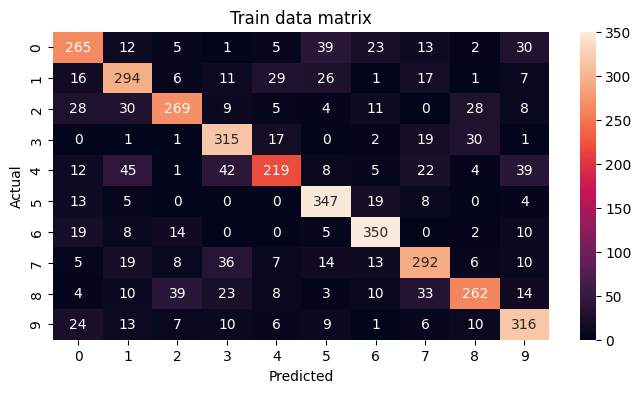

None

Test Data:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54        99
           1       0.56      0.60      0.58       102
           2       0.68      0.68      0.68        98
           3       0.64      0.69      0.66        96
           4       0.76      0.51      0.61        99
           5       0.65      0.85      0.74        99
           6       0.74      0.80      0.77       102
           7       0.68      0.64      0.66       102
           8       0.61      0.49      0.54       102
           9       0.67      0.67      0.67       101

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.64      1000



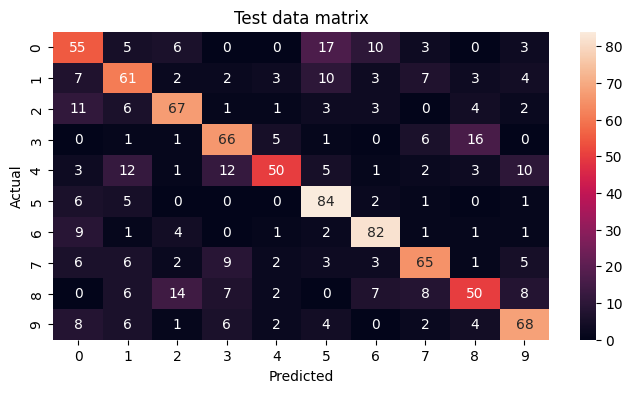

None



In [55]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train2, y_train2)
score_model(tree)

TUNED DECISION TREE

In [51]:
#Standard tree.
tuner_tree = DecisionTreeClassifier(random_state=42)

#Parameter grid.
param_grid = {"criterion":["gini","entropy"],
              "splitter":["random","best"],
              "max_depth":np.arange(1,20,2),
              "min_samples_split":[2,3,4],
              "min_samples_leaf":[1,2,3],
              "min_impurity_decrease":[0.0001,0.001,0.01],
              "ccp_alpha":np.arange(0,0.5,0.05)}

#Random search CV.
randCV = RandomizedSearchCV(estimator=tuner_tree,
                            param_distributions=param_grid,
                            n_iter=500, #500 random iterations.
                            scoring="precision_macro",
                            n_jobs=-1, #Use all available 'power'.
                            cv=10, #10 cross validation folds.
                            verbose=1, #Give me the basic details of process.
                            random_state=42,
                            error_score="raise") #Let me know the error.

#Fitting data to random search cv.
randCV.fit(x_train2,y_train2)

#Getting the best model.
tuned_tree = randCV.best_estimator_
print(f"Best score: {randCV.best_score_}")
print(f"Best parameters:{randCV.best_params_}")

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best score: 0.6531764693534088
Best parameters:{'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_depth': 17, 'criterion': 'gini', 'ccp_alpha': 0.0}


Train Data:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       395
           1       0.65      0.73      0.68       408
           2       0.75      0.68      0.71       392
           3       0.70      0.80      0.75       386
           4       0.74      0.50      0.60       397
           5       0.75      0.88      0.81       396
           6       0.81      0.85      0.83       408
           7       0.70      0.71      0.70       410
           8       0.74      0.63      0.68       406
           9       0.72      0.77      0.74       402

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



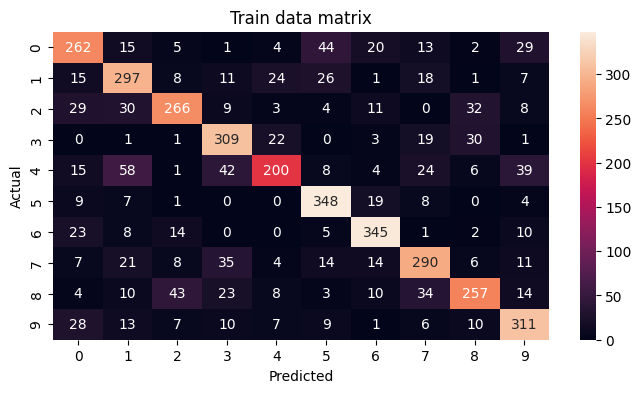

None

Test Data:
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        99
           1       0.53      0.61      0.56       102
           2       0.68      0.66      0.67        98
           3       0.65      0.70      0.67        96
           4       0.77      0.43      0.55        99
           5       0.65      0.85      0.73        99
           6       0.75      0.79      0.77       102
           7       0.68      0.66      0.67       102
           8       0.60      0.49      0.54       102
           9       0.66      0.66      0.66       101

    accuracy                           0.64      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.65      0.64      0.64      1000



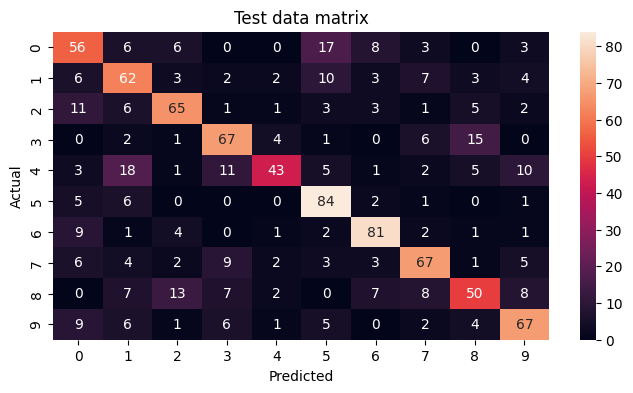

None



In [54]:
score_model(tuned_tree)

Pruned Decision Tree

In [64]:
def visualize_prec_alpha(tree_model):
  '''visualizes the loss in precision as the cost complexity parameter
  is increased.'''

  #Alphas and impurities.
  cost_path = tree_model.cost_complexity_pruning_path(x_train2,y_train2)
  ccp_alphas, impurities = cost_path.ccp_alphas, cost_path.impurities

  #Classifiers
  clfs = []
  for ccp_alpha in ccp_alphas:
      clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
      clf.fit(x_train2, y_train2)
      clfs.append(clf)

  #Ommit the last classifier that is a fully grown tree. Extreme case.
  clfs = clfs[:-1]
  ccp_alphas = ccp_alphas[:-1]
  impurities = impurities[:-1]

  #train and test f1 scores.
  prec_train_scores = []
  for clf in clfs:
    pred_train = clf.predict(x_train2)
    prec_train = precision_score(y_train2, pred_train, average="macro")
    prec_train_scores.append(prec_train)

  prec_test_scores = []
  for clf in clfs:
    pred_test = clf.predict(x_test2)
    prec_test = precision_score(y_test2, pred_test, average="macro")
    prec_test_scores.append(prec_test)

  #Plottng comparison graph.
  fig, ax = plt.subplots(figsize=(10,7))
  ax.plot(ccp_alphas, prec_train_scores, marker ="o", drawstyle = "steps-post", label="Train")
  ax.plot(ccp_alphas, prec_test_scores, marker="o", drawstyle = "steps-post", label="Test")
  plt.title("Train and Test F1 Scores vs Cost Complexity Parameter")
  plt.xlabel("Cost Complexity Parameter")
  plt.ylabel("F1 Score")
  ax.legend()
  plt.show()

  #Returning the best model parameters.
  best_model_index = np.argmax(prec_test_scores)
  best_model = clfs[best_model_index]
  print(best_model)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

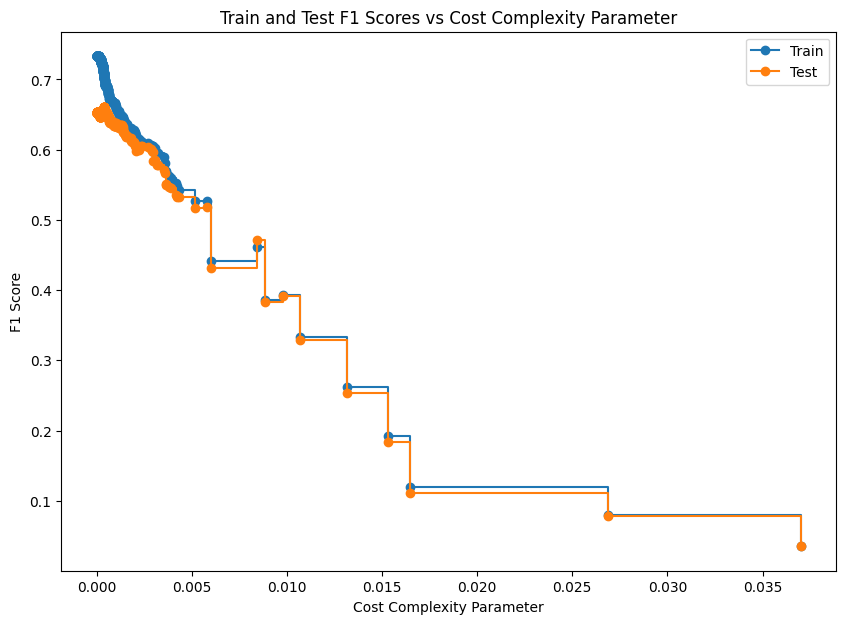

DecisionTreeClassifier(ccp_alpha=0.00039285714285714336, random_state=42)


In [65]:
pruned_tree = DecisionTreeClassifier(random_state=42)
visualize_prec_alpha(pruned_tree)

Train Data:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       395
           1       0.60      0.68      0.63       408
           2       0.77      0.61      0.68       392
           3       0.68      0.78      0.73       386
           4       0.68      0.53      0.60       397
           5       0.80      0.81      0.81       396
           6       0.80      0.84      0.82       408
           7       0.67      0.70      0.68       410
           8       0.72      0.60      0.66       406
           9       0.70      0.79      0.74       402

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000



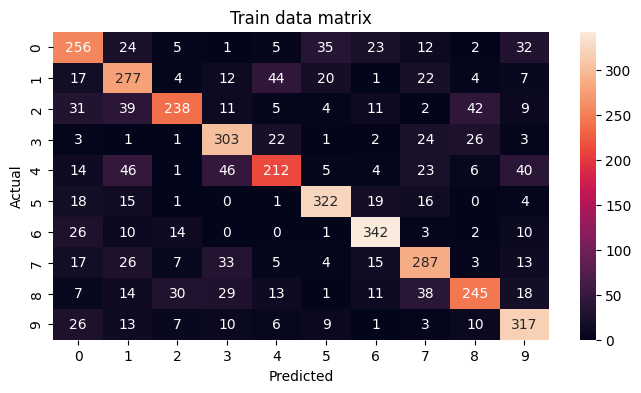

None

Test Data:
              precision    recall  f1-score   support

           0       0.56      0.61      0.58        99
           1       0.59      0.62      0.60       102
           2       0.74      0.63      0.68        98
           3       0.63      0.69      0.66        96
           4       0.72      0.53      0.61        99
           5       0.68      0.80      0.73        99
           6       0.74      0.79      0.76       102
           7       0.63      0.65      0.64       102
           8       0.66      0.58      0.61       102
           9       0.67      0.69      0.68       101

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



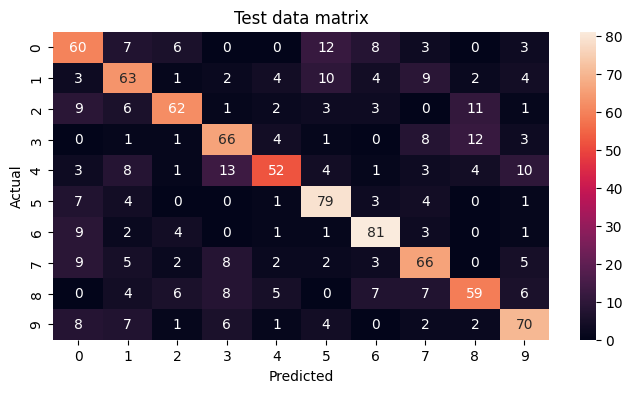

None



In [66]:
pruned_tree = DecisionTreeClassifier(random_state=42,
                                     ccp_alpha=0.00039285714285714336)

pruned_tree.fit(x_train2,y_train2)
score_model(pruned_tree)

In [67]:
tree_df = {"Model":["Baisc Tree","Tuned Tree","Pruned Tree"],
           "Train Precision": [0.73,0.72,0.70],
           "Test Precision": [0.65,0.65,0.66]}

tree_df = pd.DataFrame(tree_df)
print(tree_df)

         Model  Train Precision  Test Precision
0   Baisc Tree             0.73            0.65
1   Tuned Tree             0.72            0.65
2  Pruned Tree             0.70            0.66


Extremely similar performance between all models. I would chose the basic model if saving computer resources is the priority and the pruned tree for performance as it did generalize the best out of the three but not by much.

In [68]:
print("*"*100)

****************************************************************************************************


RANDOM FOREST

Train Data:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       395
           1       0.69      0.70      0.69       408
           2       0.78      0.67      0.72       392
           3       0.71      0.81      0.76       386
           4       0.69      0.59      0.64       397
           5       0.76      0.88      0.82       396
           6       0.80      0.86      0.83       408
           7       0.71      0.72      0.71       410
           8       0.75      0.66      0.70       406
           9       0.70      0.82      0.76       402

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



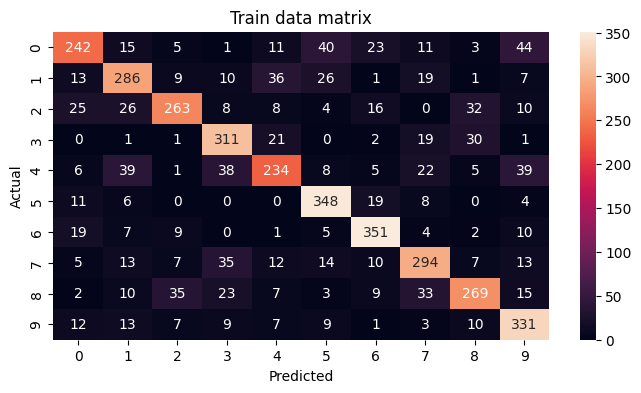

None

Test Data:
              precision    recall  f1-score   support

           0       0.56      0.49      0.52        99
           1       0.55      0.57      0.56       102
           2       0.73      0.66      0.70        98
           3       0.65      0.69      0.67        96
           4       0.66      0.53      0.58        99
           5       0.66      0.85      0.74        99
           6       0.75      0.84      0.79       102
           7       0.67      0.65      0.66       102
           8       0.61      0.53      0.57       102
           9       0.66      0.71      0.69       101

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



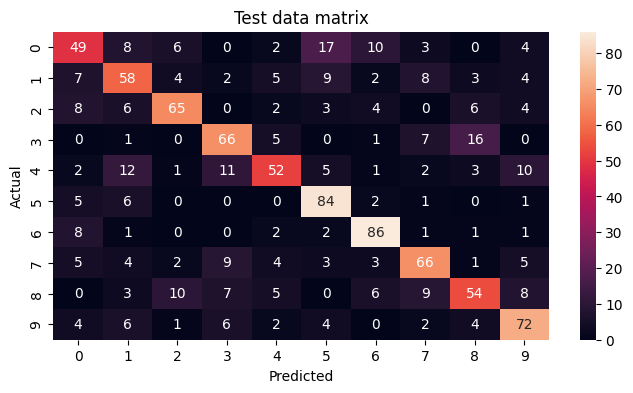

None



In [69]:
#Training a basic rf model.
rf1 = RandomForestClassifier(random_state=42)
rf1.fit(x_train2,y_train2)
score_model(rf1)

In [73]:
#Tuned random forrest.
tuner_forest = RandomForestClassifier(random_state=42)

param_grid = {"n_estimators":np.arange(100,250,50),
              "criterion":["gini","entropy"],
              "max_depth":np.arange(1,20,2),
              "max_features":["sqrt","log2",None],
              "min_impurity_decrease":[0.0001,0.001,0.01]}

randCV = RandomizedSearchCV(estimator=tuner_forest,
                            param_distributions=param_grid,
                            n_iter=100, #Random forest take longer than trees.
                            scoring="precision_macro",
                            n_jobs=-1,
                            cv=10,
                            verbose=1,
                            random_state=42,
                            error_score="raise")

randCV.fit(x_train2,y_train2)

tuned_forest = randCV.best_estimator_
print(f"Best score: {randCV.best_score_}")
print(f"Best parameters: {randCV.best_params_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best score: 0.6633709049928712
Best parameters: {'n_estimators': 150, 'min_impurity_decrease': 0.0001, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'entropy'}


Train Data:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       395
           1       0.65      0.73      0.69       408
           2       0.80      0.65      0.71       392
           3       0.73      0.79      0.76       386
           4       0.72      0.56      0.63       397
           5       0.76      0.86      0.81       396
           6       0.79      0.87      0.83       408
           7       0.71      0.71      0.71       410
           8       0.72      0.68      0.70       406
           9       0.71      0.79      0.75       402

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



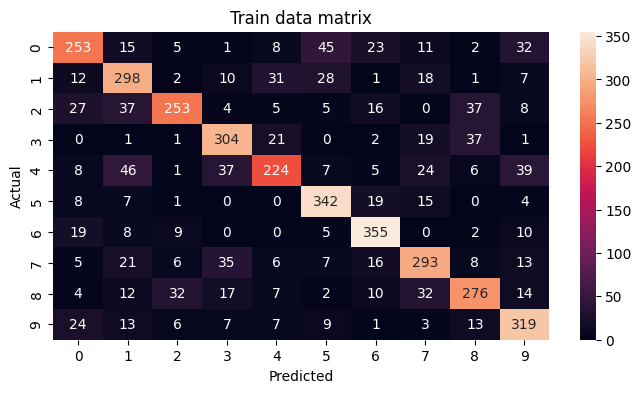

None

Test Data:
              precision    recall  f1-score   support

           0       0.54      0.51      0.52        99
           1       0.54      0.61      0.57       102
           2       0.73      0.64      0.68        98
           3       0.68      0.68      0.68        96
           4       0.77      0.51      0.61        99
           5       0.63      0.84      0.72        99
           6       0.74      0.84      0.79       102
           7       0.65      0.64      0.64       102
           8       0.59      0.56      0.58       102
           9       0.67      0.67      0.67       101

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



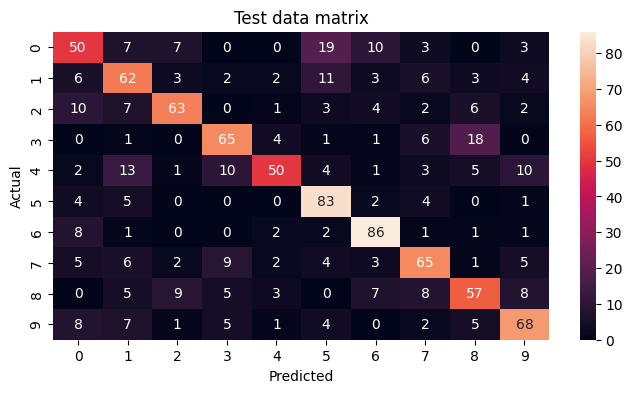

None



In [74]:
#Scoring the best tuned model.
score_model(tuned_forest)

In [75]:
forest_df = {"Model": ["Basic","Tuned"],
             "Train": [0.73,0.73],
             "Test":[0.65,0.65]}

forest_df = pd.DataFrame(forest_df)
print(forest_df)

   Model  Train  Test
0  Basic   0.73  0.65
1  Tuned   0.73  0.65


Vritually the same result as the decision trees. I'm beginnig to suspect that the classes that have barely any data to them will need to be dropped as they are causing a lot of difficulty in identifying them.

In [76]:
print("*"*100)

****************************************************************************************************


ADABOOST

Train Data:
              precision    recall  f1-score   support

           0       0.33      0.26      0.29       395
           1       0.31      0.42      0.35       408
           2       0.37      0.27      0.31       392
           3       0.39      0.47      0.43       386
           4       0.34      0.16      0.22       397
           5       0.51      0.56      0.54       396
           6       0.42      0.71      0.53       408
           7       0.54      0.45      0.49       410
           8       0.28      0.15      0.19       406
           9       0.40      0.52      0.45       402

    accuracy                           0.40      4000
   macro avg       0.39      0.40      0.38      4000
weighted avg       0.39      0.40      0.38      4000



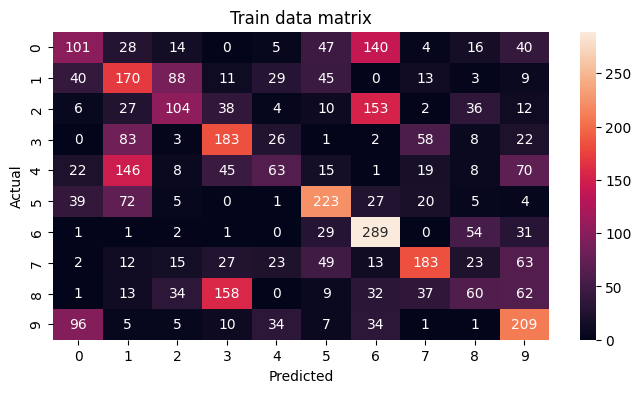

None

Test Data:
              precision    recall  f1-score   support

           0       0.32      0.21      0.26        99
           1       0.30      0.37      0.33       102
           2       0.38      0.26      0.31        98
           3       0.40      0.51      0.45        96
           4       0.31      0.13      0.18        99
           5       0.44      0.56      0.49        99
           6       0.39      0.72      0.50       102
           7       0.47      0.37      0.42       102
           8       0.30      0.20      0.24       102
           9       0.44      0.51      0.47       101

    accuracy                           0.38      1000
   macro avg       0.38      0.38      0.37      1000
weighted avg       0.38      0.38      0.37      1000



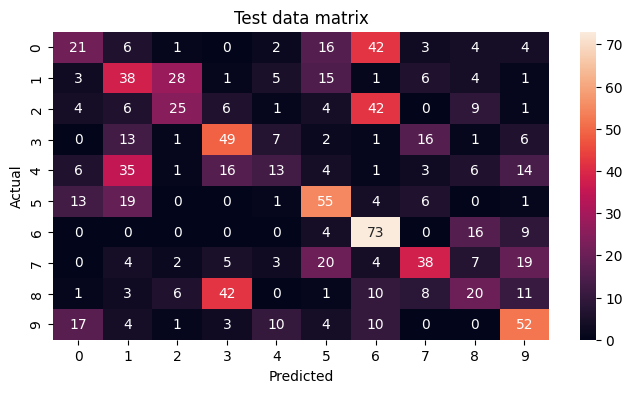

None



In [77]:
basic_ada = AdaBoostClassifier(random_state=42)
basic_ada.fit(x_train2,y_train2)
score_model(basic_ada)

In [82]:
#Tuning adaboost model.
tuned_ada = AdaBoostClassifier(random_state=42)

param_grid = {"learning_rate":np.arange(0.25,2.25,0.25),
              "n_estimators":np.arange(50,200,50)}

randCV = RandomizedSearchCV(estimator=tuned_ada,
                            param_distributions=param_grid,
                            n_iter=24,
                            scoring="precision_macro",
                            n_jobs=-1,
                            cv=10,
                            verbose=1,
                            random_state=42,
                            error_score="raise")

randCV.fit(x_train2,y_train2)

tuned_ada = randCV.best_estimator_
print(f"Best score: {randCV.best_score_}")
print(f"Best params: {randCV.best_params_}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best score: 0.5411601355402694
Best params: {'n_estimators': 50, 'learning_rate': 0.25}


Train Data:
              precision    recall  f1-score   support

           0       0.71      0.25      0.37       395
           1       0.36      0.61      0.45       408
           2       0.66      0.46      0.54       392
           3       0.84      0.35      0.49       386
           4       0.34      0.62      0.44       397
           5       0.53      0.43      0.47       396
           6       0.54      0.69      0.60       408
           7       0.52      0.37      0.43       410
           8       0.56      0.50      0.53       406
           9       0.48      0.63      0.54       402

    accuracy                           0.49      4000
   macro avg       0.55      0.49      0.49      4000
weighted avg       0.55      0.49      0.49      4000



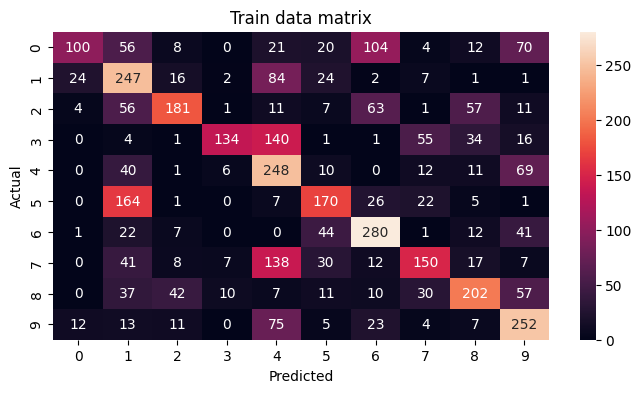

None

Test Data:
              precision    recall  f1-score   support

           0       0.79      0.23      0.36        99
           1       0.36      0.62      0.45       102
           2       0.65      0.51      0.57        98
           3       0.80      0.34      0.48        96
           4       0.37      0.61      0.46        99
           5       0.44      0.36      0.40        99
           6       0.51      0.68      0.58       102
           7       0.44      0.32      0.37       102
           8       0.54      0.55      0.54       102
           9       0.47      0.53      0.50       101

    accuracy                           0.48      1000
   macro avg       0.54      0.48      0.47      1000
weighted avg       0.53      0.48      0.47      1000



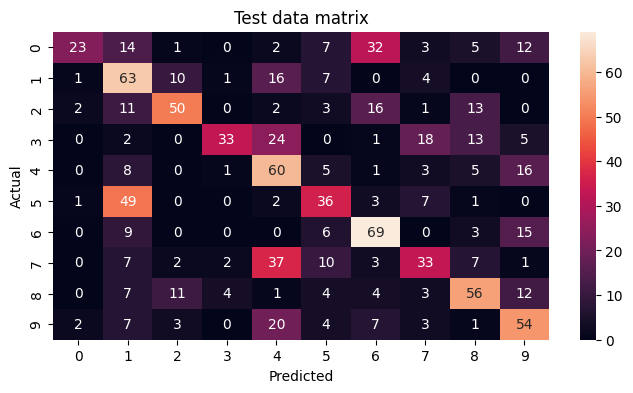

None



In [84]:
score_model(tuned_ada)

In [85]:
ada_df = {"Model":["Basic","Tuned"],
          "Train":[0.39,0.55],
          "Test":[0.38,0.54]}

ada_df = pd.DataFrame(ada_df)
print(ada_df)

   Model  Train  Test
0  Basic   0.39  0.38
1  Tuned   0.55  0.54


This model saw significant improvment after tuning unlike the tree-based models. However, the overall performance is much worse.

In [114]:
#Exporting the best model.
#They all had roughly the same score so I will pick the most simple one.
#Which is the basic tree.
pickle_operation(tree,"Decision_Tree.model","save")

Model saved as Decision_Tree.model


In [83]:
print("*"*100)

****************************************************************************************************


I believe that the categories with too few data points are at the core of the problem with poor classifiaction scores. As such, I will remove all categories that are not statistically significant (less than 5%) and re-run the tree based models.
Deleting data with too few entries (value_counts < 5%).

In [98]:
#The threshold that the value counts for a category cannot be lower than.
threshold = 0.05

cat_cols = df.select_dtypes(include="object").columns.tolist()
cat_cols.remove("Order")
df_filtered = df.copy()

for feature in cat_cols:
  value_counts = df[feature].value_counts(normalize=True)
  categories_to_remove = value_counts[value_counts < threshold].index
  df_filtered = df_filtered[~df_filtered[feature].isin(categories_to_remove)]

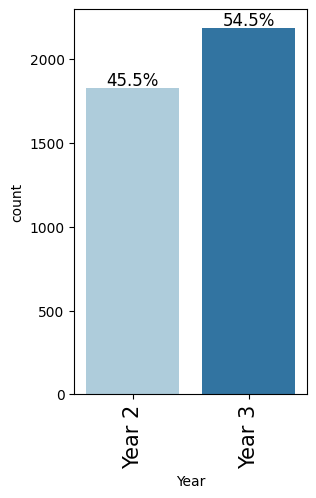

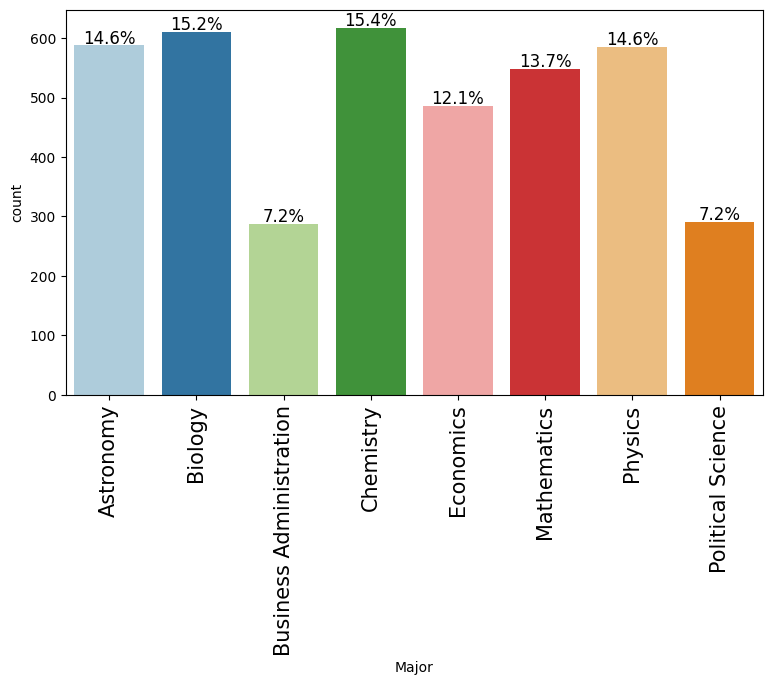

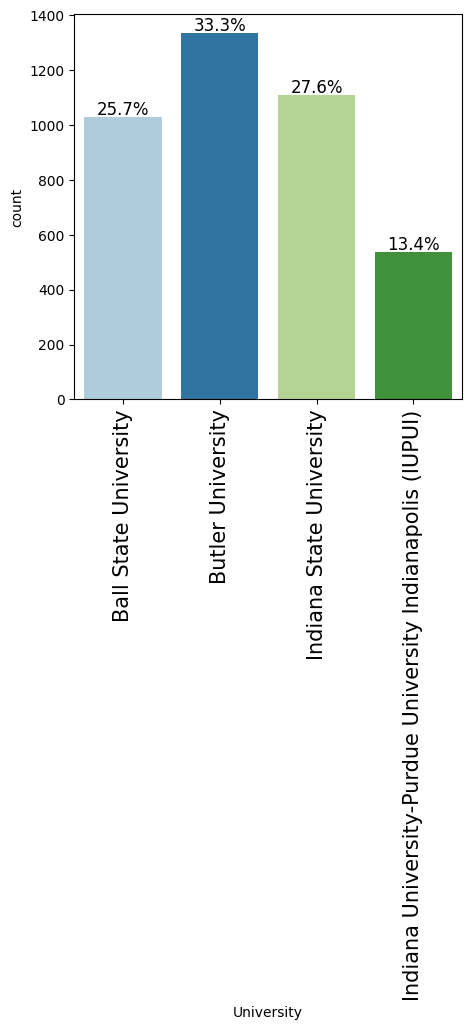

In [101]:
for feature in cat_cols:
  labeled_barplot(df_filtered,feature,perc=True)

Slighty altering function to adjust to removed rows and getting train/test variables.

In [102]:
#Re-doing preprocess pipeline with slight changes.
x = df_filtered.drop("Order", axis=1)
y = df_filtered["Order"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")

print(f"Y_train shape: {y_train.shape}")
print(f"Y_test shape: {y_test.shape}")

X_train shape: (3211, 4)
X_test shape: (803, 4)
Y_train shape: (3211,)
Y_test shape: (803,)


In [103]:
def process_df(df):
  '''Takes in the unprocessed datafarme
  and takes the necessary processing
  steps before one hot encoding and
  standardization.'''

  #Fix the 'Year' feature.
  year_replacement = {"Year 2":2,"Year 3":3}

  df["year"] = df["Year"].replace(year_replacement)

  #Switch object to category dtype.
  cat_cols = df.select_dtypes(include="object").columns
  for feature in cat_cols:
    df[feature] = df[feature].astype('category')

  #Return modified dataframe.
  return df

#Making the function usable in a pipeline.
process_df_func = FunctionTransformer(process_df)

In [104]:
pipeline = make_pipeline(
    process_df_func,
    preprocessor
)

#Applying the pipeline to independent varaibles
x_train2 = pipeline.fit_transform(x_train)
x_test2 = pipeline.transform(x_test)

#Applying LabelEncoder to dependent variable.
label_encoder = LabelEncoder()
y_train2 = label_encoder.fit_transform(y_train)
y_test2 = label_encoder.transform(y_test)

RETRAINING CLASSIFIERS

Train Data:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       287
           1       0.64      0.65      0.65       298
           2       0.69      0.68      0.69       311
           3       0.69      0.80      0.74       333
           4       0.65      0.44      0.53       286
           5       0.70      0.90      0.79       301
           6       0.82      0.83      0.82       393
           7       0.68      0.68      0.68       329
           8       0.70      0.58      0.64       324
           9       0.68      0.78      0.73       349

    accuracy                           0.70      3211
   macro avg       0.69      0.69      0.69      3211
weighted avg       0.70      0.70      0.69      3211



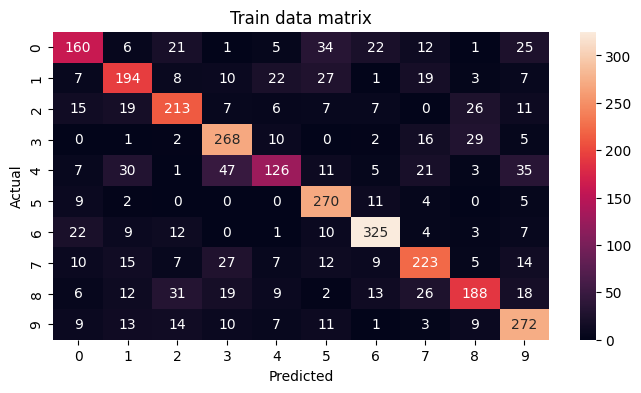

None

Test Data:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51        72
           1       0.57      0.58      0.58        74
           2       0.64      0.59      0.61        78
           3       0.68      0.76      0.72        84
           4       0.54      0.41      0.46        71
           5       0.71      0.87      0.78        75
           6       0.81      0.75      0.78        99
           7       0.62      0.66      0.64        82
           8       0.66      0.47      0.55        81
           9       0.56      0.74      0.64        87

    accuracy                           0.64       803
   macro avg       0.63      0.63      0.63       803
weighted avg       0.64      0.64      0.63       803



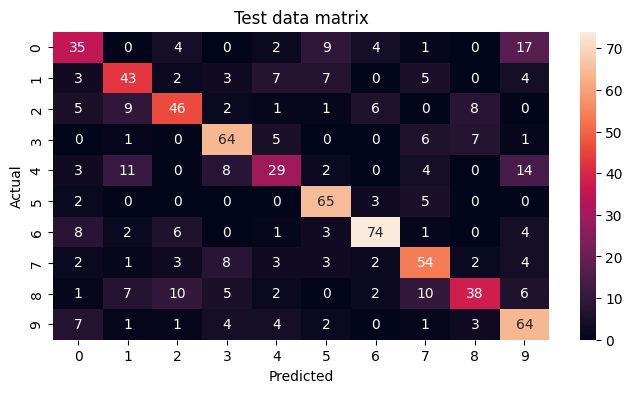

None



In [105]:
#Retraining
basic_decision = DecisionTreeClassifier(random_state=42)
basic_decision.fit(x_train2,y_train2)
score_model(basic_decision)

Train Data:
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       287
           1       0.66      0.63      0.65       298
           2       0.70      0.67      0.69       311
           3       0.69      0.80      0.74       333
           4       0.62      0.45      0.53       286
           5       0.70      0.90      0.79       301
           6       0.81      0.84      0.82       393
           7       0.67      0.69      0.68       329
           8       0.70      0.59      0.64       324
           9       0.68      0.79      0.73       349

    accuracy                           0.70      3211
   macro avg       0.69      0.69      0.69      3211
weighted avg       0.69      0.70      0.69      3211



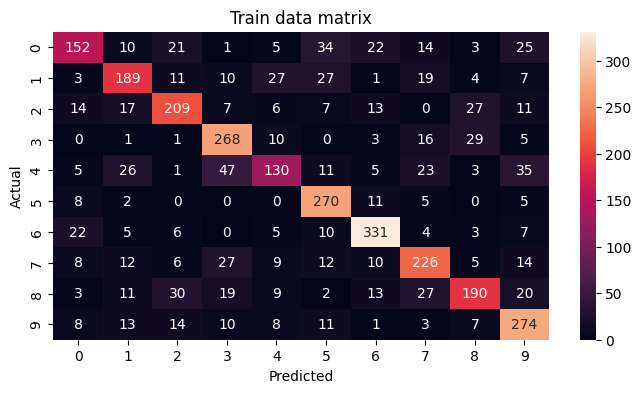

None

Test Data:
              precision    recall  f1-score   support

           0       0.58      0.49      0.53        72
           1       0.57      0.55      0.56        74
           2       0.66      0.59      0.62        78
           3       0.68      0.76      0.72        84
           4       0.53      0.41      0.46        71
           5       0.71      0.88      0.79        75
           6       0.82      0.78      0.80        99
           7       0.62      0.66      0.64        82
           8       0.66      0.51      0.57        81
           9       0.57      0.76      0.65        87

    accuracy                           0.65       803
   macro avg       0.64      0.64      0.63       803
weighted avg       0.65      0.65      0.64       803



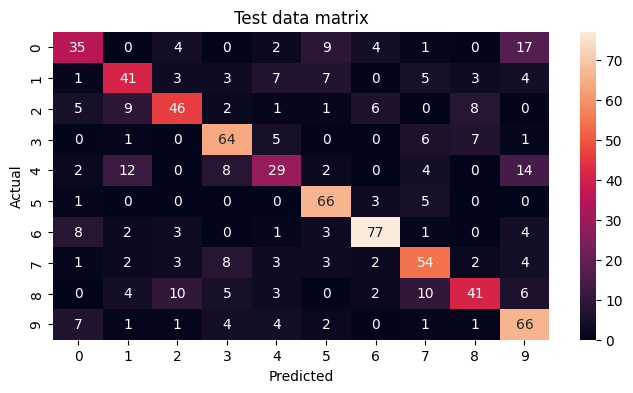

None



In [107]:
#Random forest.
basic_forest = RandomForestClassifier(random_state=42)
basic_forest.fit(x_train2,y_train2)
score_model(basic_forest)

Looks like my suspision was not supported by the results

In [109]:
print("*"*100)

****************************************************************************************************


NEURAL NETWORK

I re-rant the original train_test_split so that the complete original data is used for this network.

In [138]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, optimizers, Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical
from keras.metrics import Precision

In [142]:
#Adjusting y-variables.
y_train2 = to_categorical(y_train2, num_classes=10)
y_test2 = to_categorical(y_test2, num_classes=10)

In [156]:
model = Sequential()
model.add(Dense(256,activation="relu",input_shape=(35,))) #x_train has 35 features.
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["Precision"])

history = model.fit(x_train2,y_train2,epochs=50,batch_size=32,
                    validation_data=(x_test2,y_test2), verbose=2)

Epoch 1/50
125/125 - 3s - loss: 1.6778 - precision: 0.7362 - val_loss: 1.2285 - val_precision: 0.7154 - 3s/epoch - 28ms/step
Epoch 2/50
125/125 - 0s - loss: 1.1512 - precision: 0.7191 - val_loss: 1.1168 - val_precision: 0.7284 - 347ms/epoch - 3ms/step
Epoch 3/50
125/125 - 0s - loss: 1.0595 - precision: 0.7355 - val_loss: 1.0524 - val_precision: 0.7436 - 351ms/epoch - 3ms/step
Epoch 4/50
125/125 - 0s - loss: 1.0096 - precision: 0.7400 - val_loss: 1.0420 - val_precision: 0.7452 - 352ms/epoch - 3ms/step
Epoch 5/50
125/125 - 0s - loss: 0.9737 - precision: 0.7434 - val_loss: 1.0205 - val_precision: 0.7422 - 325ms/epoch - 3ms/step
Epoch 6/50
125/125 - 0s - loss: 0.9453 - precision: 0.7643 - val_loss: 0.9999 - val_precision: 0.7361 - 357ms/epoch - 3ms/step
Epoch 7/50
125/125 - 0s - loss: 0.9350 - precision: 0.7642 - val_loss: 0.9946 - val_precision: 0.7468 - 349ms/epoch - 3ms/step
Epoch 8/50
125/125 - 0s - loss: 0.9107 - precision: 0.7621 - val_loss: 0.9982 - val_precision: 0.7274 - 347ms/epo

10%

The work required to bring this type of a solution into fruition is not a lot and is very doable. This is including model deployment and re-training on new data to adjust the model. However, given the fact that even the neural network could not get a validation precision score of more than 72%, the business model is not viable with the given data. If you have to give a 10% discount 30% of the time, it will most likely cut into your profits too much and force you to run out of money.

My recommendation, if you're hell bent on going through with this idea, is to gather different variables in your data. Relevant variables such as where they are ethnically from, their preference of sauce, or other food related questions will actually give you relevant information that the models can owrk with. What year of school the student is and what major they are can only provide you with so much weak association.

IF you have further questions feel free to reach out! :D